<a href="https://colab.research.google.com/github/ramapriyakj/CV-ParkingPilot/blob/master/Vienna_dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integration with google drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
data_set_dir = root_dir + 'Colab Notebooks/dataset/'

Mounted at /content/gdrive


**Vienna Scooter Data Analysis**

In this project, we predict latitude and longitude of a vehicle at time on day, uisng vienna_scooter_positions.csv dataset.

The performance is evaluated using the following models:

DENSE - Dense feed forward network
LSTM - Long short term memory

CSV path

In [0]:
import os,sys
data_path = data_set_dir + "vienna_scooter_positions.csv";
if os.path.isfile(data_path):    
    pass
else:
    print("Invalid file path. Please place the python file in the same folder as vienna_scooter_positions.csv and rerun.")
    sys.exit(0)

Required libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from prettytable import PrettyTable

Using TensorFlow backend.


Read CSV

In [4]:
header = ["id","lat","lon","time"]
ori = pd.read_csv(data_path)[header]
ori.head()

,id,lat,lon,time
0,EMTRPL,48.184833,16.416045,4.59.57
1,RSPUIN,48.220575,16.356078,4.59.57
2,LHCMAF,48.193983,16.399211,4.59.57
3,JZKAIQ,48.202690,16.393311,4.59.57
4,WHLPTK,48.226330,16.352546,4.59.57


Convert categorical variable into integer using label encoder

In [5]:
le = preprocessing.LabelEncoder()
le.fit(ori["id"])
total_vehicles = len(le.classes_)
print("Total Vehicles are : ",total_vehicles)

Total Vehicles are :  997


1.   Time is split into hours, minutes and seconds
2.   All features are converted to float. Now the data contains id, latitude, longitide, hours, minutes and seconds

In [6]:
_id = le.transform(ori["id"])
data = np.zeros((len(ori), len(header) + 2))
for i, line in ori.iterrows():
  time = line["time"].split('.')
  data[i, :] = [_id[i],float(line["lat"]),float(line["lon"]),float(time[0]),float(time[1]),float(time[2])]
print(data.shape)

(869641, 6)


In [0]:
ori.drop(header, axis=1, inplace=True)

**Feature Normalization**

1.   All features except id are normalized
2.   Mean and Standard deviation are calculated on training data (first 600000 records) and the same values are used to normalize entire dataset



In [0]:
mean = data[:600000,1:].mean(axis=0)
data[:,1:] -= mean
std = data[:600000,1:].std(axis=0)
data[:,1:] /= std

The following function takes lookback (default = 50) and step (default = 10)  as input and returns train dataset, validation dataset and test dataset.

For each sample in the original dataset, the vehicle id is noted and lookback number of previous positions are sampled and returned as features.

It returns training, validation and testing datasets.
Traning dataset size = 600000
Traning dataset size = 100000
Traning dataset size = Remaining samples


In [0]:
def getDataSet(lookback,step):
    trainable_x = np.zeros((len(data), step, data.shape[-1]))
    trainable_y = np.zeros((len(data),2))
    lookback_list = {}
    for i in range(total_vehicles):
      lookback_list[i] = np.array([[i,0,0,0,0,0]]*lookback)
      
    ind = np.arange(0,lookback,lookback//step)
    
    for i,row in enumerate(data):
      id = int(row[0])   
      trainable_x[i,:,:] = lookback_list[id][ind,:]
      trainable_y[i] = np.array([row[1],row[2]])
      lookback_list[id] = np.concatenate((lookback_list[id][1:],[row]))        
    
    indices = np.arange(600000)
    np.random.shuffle(indices)
    train_x = trainable_x[indices]
    train_y = trainable_y[indices]
    val_x = trainable_x[600000:700000]
    val_y = trainable_y[600000:700000]
    test_x = trainable_x[700000:]
    test_y = trainable_y[700000:]
    
    return train_x,train_y,val_x,val_y,test_x,test_y

Plot loss using matplotlib

In [0]:
def printResults(name,history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title(name + ' - Training and validation loss')
  plt.legend()

  plt.show()

The function creates and trains model, return test result. Only two models are used for demonstration : DENSE and LSTM.

In [0]:
def getResult(name,lookback,step,batch_size,epochs):
  
  train_x,train_y,val_x,val_y,test_x,test_y = getDataSet(lookback,step)
  
  model = None
  history = None
  
  if name == "DENSE":
    model = Sequential()
    model.add(layers.Flatten(input_shape=(step, train_x.shape[-1])))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(2))
    model.compile(optimizer=RMSprop(), loss='mse', metrics = ['mae'])
    history = model.fit(train_x,train_y,batch_size=batch_size,epochs=epochs,validation_data=(val_x,val_y)) 
  elif name == "LSTM":
    model = Sequential()
    model.add(layers.LSTM(32,dropout=0.1,recurrent_dropout=0.5,input_shape=(None, train_x.shape[-1])))
    model.add(layers.Dense(2))
    model.compile(optimizer=RMSprop(), loss='mse', metrics = ['mae'])
    history = model.fit(train_x,train_y,batch_size=batch_size,epochs=epochs,validation_data=(val_x,val_y))
  
  printResults(name,history)
  mse, mae = model.evaluate(test_x, test_y, verbose=0)
  return mae

Evaluate Model

Train on 600000 samples, validate on 100000 samples
Epoch 1/5
600000/600000 [==============================] - 40s 67us/step - loss: 0.2851 - mean_absolute_error: 0.3758 - val_loss: 0.0519 - val_mean_absolute_error: 0.1682
Epoch 2/5
600000/600000 [==============================] - 39s 65us/step - loss: 0.0887 - mean_absolute_error: 0.2105 - val_loss: 0.0477 - val_mean_absolute_error: 0.1758
Epoch 3/5
600000/600000 [==============================] - 40s 66us/step - loss: 0.0752 - mean_absolute_error: 0.1912 - val_loss: 0.0574 - val_mean_absolute_error: 0.1952
Epoch 4/5
600000/600000 [==============================] - 39s 64us/step - loss: 0.0680 - mean_absolute_error: 0.1797 - val_loss: 0.0301 - val_mean_absolute_error: 0.1275
Epoch 5/5
600000/600000 [==============================] - 41s 68us/step - loss: 0.0622 - mean_absolute_error: 0.1699 - val_loss: 0.0168 - val_mean_absolute_error: 0.0911


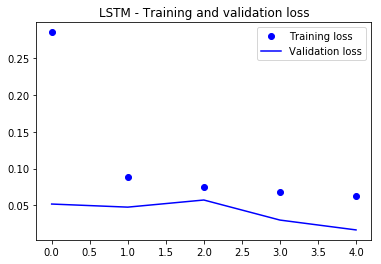

Model: LSTM ,Look Back: 20 ,Epoch: 5 ,MAE: 0.092838602384377
Train on 600000 samples, validate on 100000 samples
Epoch 1/10
600000/600000 [==============================] - 41s 68us/step - loss: 0.2771 - mean_absolute_error: 0.3686 - val_loss: 0.0636 - val_mean_absolute_error: 0.1990
Epoch 2/10
600000/600000 [==============================] - 41s 68us/step - loss: 0.0902 - mean_absolute_error: 0.2113 - val_loss: 0.0880 - val_mean_absolute_error: 0.2309
Epoch 3/10
600000/600000 [==============================] - 40s 67us/step - loss: 0.0761 - mean_absolute_error: 0.1912 - val_loss: 0.0225 - val_mean_absolute_error: 0.1056
Epoch 4/10
600000/600000 [==============================] - 41s 69us/step - loss: 0.0683 - mean_absolute_error: 0.1791 - val_loss: 0.0289 - val_mean_absolute_error: 0.1199
Epoch 5/10
600000/600000 [==============================] - 40s 66us/step - loss: 0.0626 - mean_absolute_error: 0.1703 - val_loss: 0.0155 - val_mean_absolute_error: 0.0807
Epoch 6/10
600000/600000 [=

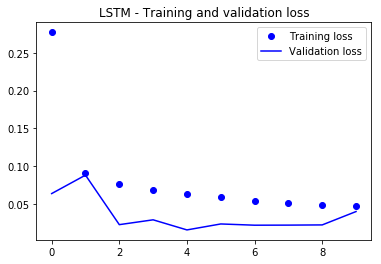

Model: LSTM ,Look Back: 20 ,Epoch: 10 ,MAE: 0.15304070616743662
Train on 600000 samples, validate on 100000 samples
Epoch 1/5
600000/600000 [==============================] - 59s 98us/step - loss: 0.3100 - mean_absolute_error: 0.3864 - val_loss: 0.1270 - val_mean_absolute_error: 0.2662
Epoch 2/5
600000/600000 [==============================] - 58s 96us/step - loss: 0.0838 - mean_absolute_error: 0.2069 - val_loss: 0.0266 - val_mean_absolute_error: 0.1222
Epoch 3/5
600000/600000 [==============================] - 56s 94us/step - loss: 0.0678 - mean_absolute_error: 0.1834 - val_loss: 0.0315 - val_mean_absolute_error: 0.1369
Epoch 4/5
600000/600000 [==============================] - 57s 95us/step - loss: 0.0606 - mean_absolute_error: 0.1718 - val_loss: 0.0320 - val_mean_absolute_error: 0.1288
Epoch 5/5
600000/600000 [==============================] - 58s 96us/step - loss: 0.0558 - mean_absolute_error: 0.1632 - val_loss: 0.0290 - val_mean_absolute_error: 0.1311


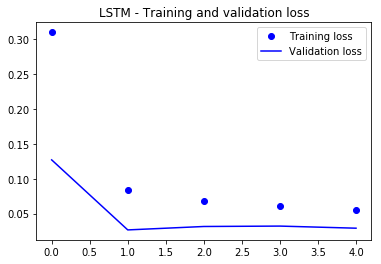

Model: LSTM ,Look Back: 30 ,Epoch: 5 ,MAE: 0.13043313372750812
Train on 600000 samples, validate on 100000 samples
Epoch 1/10
600000/600000 [==============================] - 59s 99us/step - loss: 0.2948 - mean_absolute_error: 0.3804 - val_loss: 0.0552 - val_mean_absolute_error: 0.1937
Epoch 2/10
600000/600000 [==============================] - 57s 95us/step - loss: 0.0880 - mean_absolute_error: 0.2115 - val_loss: 0.0297 - val_mean_absolute_error: 0.1281
Epoch 3/10
600000/600000 [==============================] - 57s 95us/step - loss: 0.0721 - mean_absolute_error: 0.1892 - val_loss: 0.0241 - val_mean_absolute_error: 0.1158
Epoch 4/10
600000/600000 [==============================] - 57s 95us/step - loss: 0.0632 - mean_absolute_error: 0.1751 - val_loss: 0.0422 - val_mean_absolute_error: 0.1505
Epoch 5/10
600000/600000 [==============================] - 55s 92us/step - loss: 0.0572 - mean_absolute_error: 0.1656 - val_loss: 0.0195 - val_mean_absolute_error: 0.1040
Epoch 6/10
600000/600000 

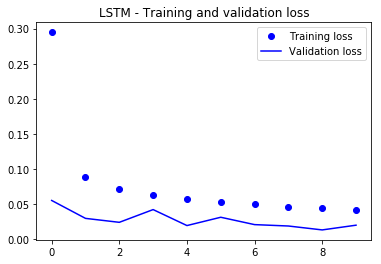

Model: LSTM ,Look Back: 30 ,Epoch: 10 ,MAE: 0.1048062993470739
Train on 600000 samples, validate on 100000 samples
Epoch 1/5
600000/600000 [==============================] - 5s 8us/step - loss: 254.8904 - mean_absolute_error: 12.0008 - val_loss: 236.0962 - val_mean_absolute_error: 12.6850
Epoch 2/5
600000/600000 [==============================] - 4s 6us/step - loss: 142.2215 - mean_absolute_error: 8.7227 - val_loss: 78.8480 - val_mean_absolute_error: 7.3263
Epoch 3/5
600000/600000 [==============================] - 4s 6us/step - loss: 71.9880 - mean_absolute_error: 6.1887 - val_loss: 37.8430 - val_mean_absolute_error: 5.2341
Epoch 4/5
600000/600000 [==============================] - 4s 6us/step - loss: 35.5374 - mean_absolute_error: 4.6559 - val_loss: 33.3214 - val_mean_absolute_error: 4.5328
Epoch 5/5
600000/600000 [==============================] - 4s 7us/step - loss: 24.4567 - mean_absolute_error: 3.8729 - val_loss: 15.7901 - val_mean_absolute_error: 3.3136


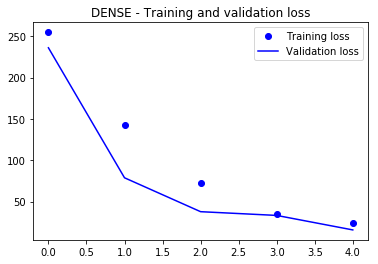

Model: DENSE ,Look Back: 20 ,Epoch: 5 ,MAE: 3.327309127529702
Train on 600000 samples, validate on 100000 samples
Epoch 1/10
600000/600000 [==============================] - 5s 8us/step - loss: 1201.7472 - mean_absolute_error: 14.2467 - val_loss: 153.8124 - val_mean_absolute_error: 10.0264
Epoch 2/10
600000/600000 [==============================] - 4s 6us/step - loss: 191.2352 - mean_absolute_error: 10.1627 - val_loss: 57.9647 - val_mean_absolute_error: 6.3754
Epoch 3/10
600000/600000 [==============================] - 4s 6us/step - loss: 110.8580 - mean_absolute_error: 7.7160 - val_loss: 28.8161 - val_mean_absolute_error: 4.6359
Epoch 4/10
600000/600000 [==============================] - 4s 6us/step - loss: 75.2230 - mean_absolute_error: 6.5704 - val_loss: 46.6730 - val_mean_absolute_error: 4.5802
Epoch 5/10
600000/600000 [==============================] - 4s 7us/step - loss: 48.2143 - mean_absolute_error: 5.1548 - val_loss: 40.7078 - val_mean_absolute_error: 4.8500
Epoch 6/10
600000/

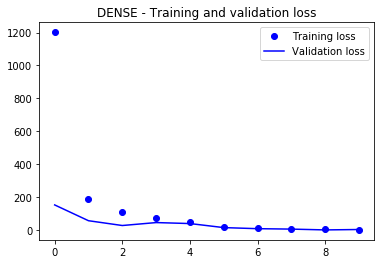

Model: DENSE ,Look Back: 20 ,Epoch: 10 ,MAE: 1.4174327966837903
Train on 600000 samples, validate on 100000 samples
Epoch 1/5
600000/600000 [==============================] - 5s 8us/step - loss: 421.2655 - mean_absolute_error: 14.9583 - val_loss: 81.1512 - val_mean_absolute_error: 6.9434
Epoch 2/5
600000/600000 [==============================] - 4s 7us/step - loss: 166.3787 - mean_absolute_error: 9.5987 - val_loss: 131.1826 - val_mean_absolute_error: 9.8410
Epoch 3/5
600000/600000 [==============================] - 4s 7us/step - loss: 89.9020 - mean_absolute_error: 7.0743 - val_loss: 89.6627 - val_mean_absolute_error: 7.7357
Epoch 4/5
600000/600000 [==============================] - 4s 7us/step - loss: 30.2769 - mean_absolute_error: 3.9558 - val_loss: 16.7827 - val_mean_absolute_error: 3.5397
Epoch 5/5
600000/600000 [==============================] - 4s 7us/step - loss: 6.4341 - mean_absolute_error: 1.6966 - val_loss: 0.7216 - val_mean_absolute_error: 0.6210


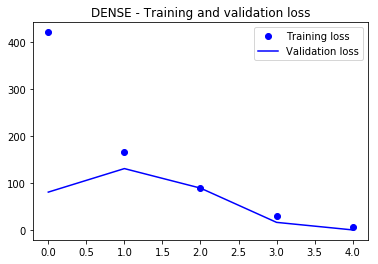

Model: DENSE ,Look Back: 30 ,Epoch: 5 ,MAE: 0.6086508053642269
Train on 600000 samples, validate on 100000 samples
Epoch 1/10
600000/600000 [==============================] - 5s 9us/step - loss: 202.8008 - mean_absolute_error: 8.2538 - val_loss: 32.6606 - val_mean_absolute_error: 3.7110
Epoch 2/10
600000/600000 [==============================] - 4s 7us/step - loss: 51.3030 - mean_absolute_error: 5.0315 - val_loss: 68.4153 - val_mean_absolute_error: 5.4437
Epoch 3/10
600000/600000 [==============================] - 5s 8us/step - loss: 17.5792 - mean_absolute_error: 2.8523 - val_loss: 10.3690 - val_mean_absolute_error: 2.5776
Epoch 4/10
600000/600000 [==============================] - 5s 8us/step - loss: 7.0361 - mean_absolute_error: 1.8400 - val_loss: 0.6432 - val_mean_absolute_error: 0.5204
Epoch 5/10
600000/600000 [==============================] - 4s 7us/step - loss: 1.8687 - mean_absolute_error: 0.8167 - val_loss: 0.4643 - val_mean_absolute_error: 0.5214
Epoch 6/10
600000/600000 [==

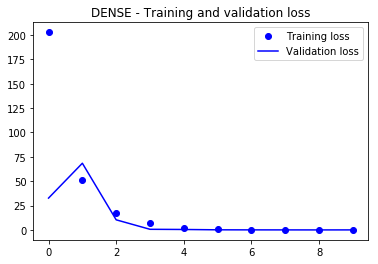

Model: DENSE ,Look Back: 30 ,Epoch: 10 ,MAE: 0.14215095266498198


In [13]:
model_names = ["LSTM","DENSE"]
look_back = [[60,20],[60,30]]
epochs = [5,10]
mae_li = []
for y in model_names:
  for x in look_back:
    for z in epochs:   
      mae = getResult(y,x[0],x[1],512,z)
      print("Model:",y,",Look Back:",x[1],",Epoch:",z,",MAE:",mae)
      mae_li.append(mae)

Results

In [14]:
print("Testing results:")
t = PrettyTable(['Model','Look Back Samples','Epochs','Mean Absolute Error'])
i = 0
for y in model_names:
  for x in look_back:
    for z in epochs:   
      t.add_row([y,x[1],z,round(mae_li[i],2)])
      i += 1
print(t)

Testing results:
+-------+-------------------+--------+---------------------+
| Model | Look Back Samples | Epochs | Mean Absolute Error |
+-------+-------------------+--------+---------------------+
|  LSTM |         20        |   5    |         0.09        |
|  LSTM |         20        |   10   |         0.15        |
|  LSTM |         30        |   5    |         0.13        |
|  LSTM |         30        |   10   |         0.1         |
| DENSE |         20        |   5    |         3.33        |
| DENSE |         20        |   10   |         1.42        |
| DENSE |         30        |   5    |         0.61        |
| DENSE |         30        |   10   |         0.14        |
+-------+-------------------+--------+---------------------+
